In [1]:
# Este ambiente Python 3 vem com muitas bibliotecas de análise úteis instaladas
# Ele é definido pela imagem Docker kaggle/python: https://github.com/kaggle/docker-python
# Por exemplo, aqui estão vários pacotes úteis para carregar

import numpy as np # álgebra linear
import pandas as pd # processamento de dados, E/S de arquivos CSV (por exemplo, pd.read_csv)


import numpy as np
from sklearn.cluster import KMeans

from minisom import MiniSom  

import matplotlib.pyplot as plt
%matplotlib inline

# Os arquivos de dados de entrada estão disponíveis no diretório somente leitura "../input/"
# Por exemplo, executar isso (clicando em executar ou pressionando Shift+Enter) listará todos os arquivos no diretório de entrada

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Você pode escrever até 20GB no diretório atual (/kaggle/working/) que é preservado como saída quando você cria uma versão usando "Salvar & Executar Tudo"
# Você também pode escrever arquivos temporários em /kaggle/temp/, mas eles não serão salvos fora da sessão atual

## Introdução

Neste notebook, demonstraremos como usar o minisom para fazer clustering de topologia linear

Por favor, vote positivamente neste notebook se achar útil :)

Jonathan Kristanto &copy; Maio 2021

## Importar Dados

In [2]:
DATA_DIR = './dataset/Mall_Customers.csv'
df = pd.read_csv(DATA_DIR)
df

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
...,...,...,...,...,...
195,196,Female,35,120,79
196,197,Female,45,126,28
197,198,Male,32,126,74
198,199,Male,32,137,18


## Seleção de Características

Veremos quais combinações de características podem ser agrupadas

### Distribuição de Dados de Idade e Pontuação de Gastos

Resultado: Nenhum cluster aparente detectado

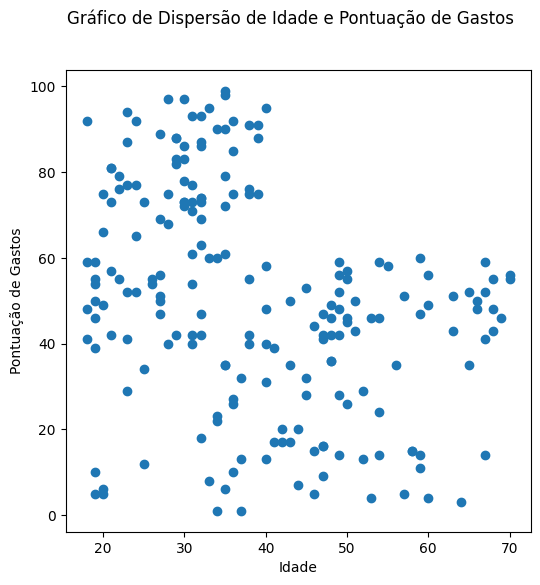

In [3]:
age = df['Age'].tolist()
spending_score = df['Spending Score (1-100)'].tolist()
annual_income = df['Annual Income (k$)'].tolist()
fig = plt.figure(figsize=(6,6))
plt.scatter(age, spending_score)
plt.suptitle("Gráfico de Dispersão de Idade e Pontuação de Gastos")
plt.xlabel("Idade")
plt.ylabel("Pontuação de Gastos")
plt.show()

### Distribuição de Dados de Idade e Renda Anual

Resultado: Nenhum cluster aparente detectado

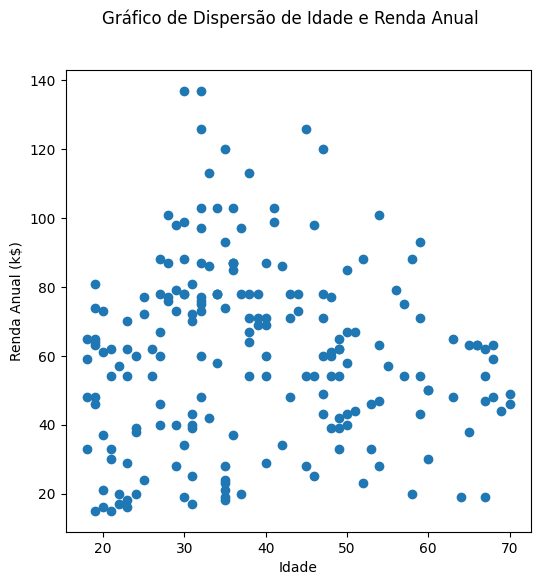

In [4]:
age = df['Age'].tolist()
annual_income = df['Annual Income (k$)'].tolist()
fig = plt.figure(figsize=(6,6))
plt.scatter(age, annual_income)
plt.suptitle("Gráfico de Dispersão de Idade e Renda Anual")
plt.xlabel("Idade")
plt.ylabel("Renda Anual (k$)")
plt.show()

### Distribuição de Dados de Renda Anual e Pontuação de Gastos

**Resultado: Existem 5 clusters detectados**

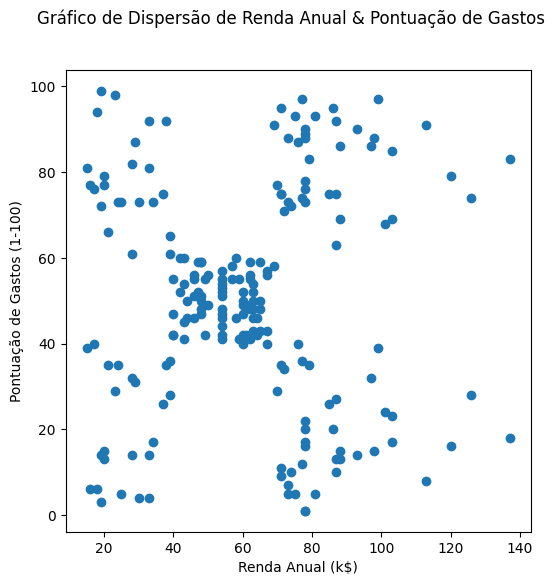

In [5]:
annual_income = df['Annual Income (k$)'].tolist()
spending_score = df['Spending Score (1-100)'].tolist()
fig = plt.figure(figsize=(6,6))
plt.scatter(annual_income, spending_score)
plt.suptitle("Gráfico de Dispersão de Renda Anual & Pontuação de Gastos")
plt.xlabel("Renda Anual (k$)")
plt.ylabel("Pontuação de Gastos (1-100)")
plt.show()

## Limpar & Transformar Dados

In [6]:
df.isnull().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

In [7]:
# Selecionar Renda Anual e Pontuação de Gastos como nossas características
features = df[['Annual Income (k$)', 'Spending Score (1-100)']]

# Transformar características em lista
data = features.values
data.shape

(200, 2)

# Parâmetros gerais do dataset

In [8]:
global_centroid = np.mean(data, axis=0) # Calcular o centróide global
F_0 = np.sum(np.linalg.norm(data - global_centroid, axis=1)**2) # Calcular F_0 (dispersão total)
n_0 = data.shape[0] # Número total de pontos
sigma_0 = np.sqrt(F_0 / n_0) # Calcular o desvio padrão total

print(f"Número total de elementos (n_0): {n_0}")
print(f"Baricentro Global (m_0): ", global_centroid)
print(f"Dispersão total (F_0): {F_0:.2f}")
print(f"Desvio padrão total (\\sigma_0): {sigma_0:.2f}")

Número total de elementos (n_0): 200
Baricentro Global (m_0):  [60.56 50.2 ]
Dispersão total (F_0): 269981.28
Desvio padrão total (\sigma_0): 36.74


# Treinamento dos Modelos

## K-means

In [9]:
def calcular_metricas_cluster(data, max_clusters=10):
    # Inicialização das listas para armazenar os resultados
    F_out_values = []
    F_in_values = []
    n_cluster_points_values = []
    centroid_values = []
    max_distance_values = []
    variancia_intra_values = []
    desvio_padrao_intra_values = []

    # Loop para diferentes números de clusters
    for n_clusters in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=n_clusters, random_state=0)
        kmeans.fit(data)
        
        # Obter os rótulos e centróides
        labels = kmeans.labels_
        centroids = kmeans.cluster_centers_

        # Calcular F_j para cada cluster
        F_j_values = []
        n_cluster_points_l_values = []
        max_distance_l_values = []
        variancia_intra_l_values = []
        desvio_padrao_intra_l_values = []
        
        # Loop sobre cada cluster
        for j in range(n_clusters):
            cluster_points = data[labels == j]  # Dados no cluster j
            centroid = centroids[j]             # Centróide do cluster j

            n_cluster_points_l_values.append(len(cluster_points))
            centroid_values.append(centroid)
            
            # Calcular dispersão intra-cluster F_j
            F_j = np.sum(np.linalg.norm(cluster_points - centroid, axis=1)**2)  # Dispersão intra-cluster
            F_j_values.append(float(F_j))
            
            # Calcular o diâmetro do cluster (maior distância entre os pontos dentro do cluster)
            max_distance = 0
            for i in range(len(cluster_points)):
                for k in range(i + 1, len(cluster_points)):
                    dist = np.linalg.norm(cluster_points[i] - cluster_points[k])
                    max_distance = max(max_distance, dist)
            
            max_distance_l_values.append(float(max_distance))
            
            # Calcular a variância intra-classe
            variancia_intra = np.mean(np.linalg.norm(cluster_points - centroid, axis=1)**2)
            variancia_intra_l_values.append(float(variancia_intra))
            
            # Calcular o desvio padrão intra-classe
            desvio_padrao_intra = np.sqrt(variancia_intra)
            desvio_padrao_intra_l_values.append(float(desvio_padrao_intra))
        
        F_in_values.append(F_j_values.copy())
        
        # Calcular F_out (dispersão inter-cluster)
        F_out = 0
        global_centroid = np.mean(centroids, axis=0)  # Centróide global (média dos centróides dos clusters)
        for j in range(n_clusters):
            cluster_points = data[labels == j]  # Dados no cluster j
            n_j = len(cluster_points)           # Número de pontos no cluster j
            centroid_j = centroids[j]           # Centróide do cluster j
            F_out += n_j * np.linalg.norm(centroid_j - global_centroid)**2

        F_out_values.append(F_out)
        n_cluster_points_values.append(n_cluster_points_l_values)
        max_distance_values.append(max_distance_l_values.copy())
        variancia_intra_values.append(variancia_intra_l_values.copy())
        desvio_padrao_intra_values.append(desvio_padrao_intra_l_values.copy())

    return F_out_values, F_in_values, n_cluster_points_values, centroid_values, max_distance_values, variancia_intra_values, desvio_padrao_intra_values

def plot_metricas_clusters(F_out_values, F_in_values, max_clusters=10):
    # Número de clusters de 1 a max_clusters
    clusters_range = range(1, max_clusters + 1)

    # Calcular a dispersão total intra-cluster (F_in) para cada número de clusters
    total_F_in_values = [sum(F_in) for F_in in F_in_values]

    # Plotar as métricas
    plt.figure(figsize=(10, 6))

    # Gráfico da dispersão intra-cluster (F_in)
    plt.plot(clusters_range, total_F_in_values, label="Dispersão Intra-cluster (F_in)", marker='o', color='blue')

    # Gráfico da dissimilaridade inter-cluster (F_out)
    plt.plot(clusters_range, F_out_values, label="Dissimilaridade Inter-cluster (F_out)", marker='x', color='red')

    # Adicionando rótulos e título
    plt.xlabel("Número de clusters")
    plt.ylabel("Valor das métricas")
    plt.title("Dispersão intra-cluster (F_in) e Dissimilaridade inter-cluster (F_out) por número de clusters")
    plt.legend()
    plt.grid(True)

    # Exibir o gráfico
    plt.show()

Clusters: 1
   Número de elementos (n_j):  [200]
   Baricentro (m_j):  [60.56 50.2 ]
   Diâmetro do cluster:  [143.42245291445826]
   Variância intra-cluster:  [1349.9064]
   Desvio padrão intra-cluster:  [36.74107238500259]
   Dispersão intra-cluster (F_ji):  [269981.28]
   Dispersão total intra-cluster (F_in): 269981.28
   Dissimilaridade inter-cluster (F_out): 0.0
Clusters: 2
   Número de elementos (n_j):  [153, 47]
   Baricentro (m_j):  [55.66013072 39.94771242]
   Diâmetro do cluster:  [137.3062270984095, 119.50732195141852]
   Variância intra-cluster:  [969.1366568413858, 800.8347668628338]
   Desvio padrão intra-cluster:  [31.130959780279596, 28.299024132694644]
   Dispersão intra-cluster (F_ji):  [148277.90849673204, 37639.23404255319]
   Dispersão total intra-cluster (F_in): 185917.14253928524
   Dissimilaridade inter-cluster (F_out): 116901.87381548414
Clusters: 3
   Número de elementos (n_j):  [123, 39, 38]
   Baricentro (m_j):  [76.5106383  83.57446809]
   Diâmetro do clust

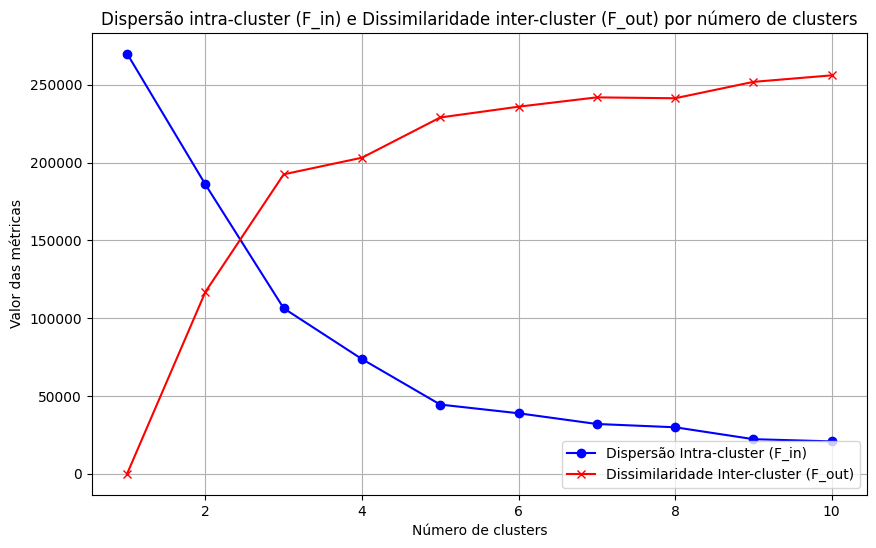

In [10]:
F_out_values, F_in_values, n_cluster_points_values, centroid_values, max_distance_values, variancia_intra_values, desvio_padrao_intra_values = calcular_metricas_cluster(data, 10)

for idx, (F_out, F_in, n_cluster_points, centroid, max_distance, variancia_intra, desvio_padrao_intra) in enumerate(zip(F_out_values, F_in_values, n_cluster_points_values, centroid_values, max_distance_values, variancia_intra_values, desvio_padrao_intra_values)):
    print(f"Clusters: {idx+1}")
    print(f"   Número de elementos (n_j): ", n_cluster_points)
    print(f"   Baricentro (m_j): ", centroid)
    print(f"   Diâmetro do cluster: ", max_distance)
    print(f"   Variância intra-cluster: ", variancia_intra)
    print(f"   Desvio padrão intra-cluster: ", desvio_padrao_intra)
    print(f"   Dispersão intra-cluster (F_ji): ", F_in)
    print(f"   Dispersão total intra-cluster (F_in): {sum(F_in)}")
    print(f"   Dissimilaridade inter-cluster (F_out): {(F_out)}")

plot_metricas_clusters(F_out_values, F_in_values, max_clusters=10)

Clusters: 4


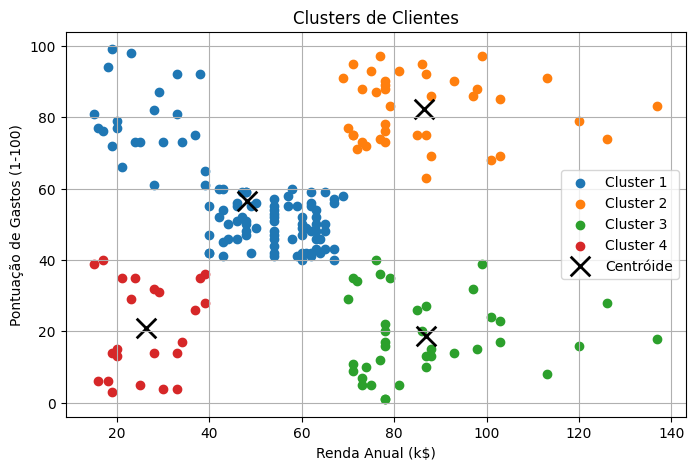

Clusters: 5


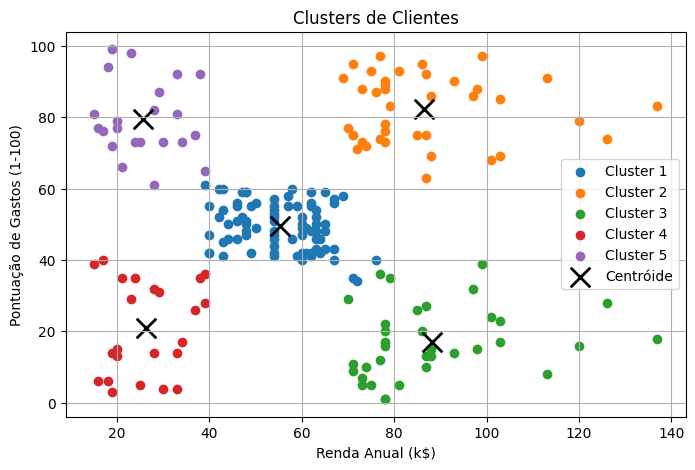

In [11]:
for optimal_clusters in [4, 5]:
    print(f"Clusters: {optimal_clusters}")
    kmeans = KMeans(n_clusters=optimal_clusters, random_state=0)
    kmeans.fit(data)
    
    # Obtendo os centróides e rótulos
    m_0 = kmeans.cluster_centers_
    labels = kmeans.labels_
    
    # Plotando os clusters e seus centróides
    plt.figure(figsize=(8, 5))
    for i in range(optimal_clusters):
        cluster_points = data[labels == i]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {i+1}")
    
    plt.scatter(m_0[:, 0], m_0[:, 1], marker='x', s=200, linewidths=2, color='k', label='Centróide')
    plt.title("Clusters de Clientes")
    plt.xlabel("Renda Anual (k$)")
    plt.ylabel("Pontuação de Gastos (1-100)")
    plt.legend()
    plt.grid()
    plt.show()

## Treinar SOM

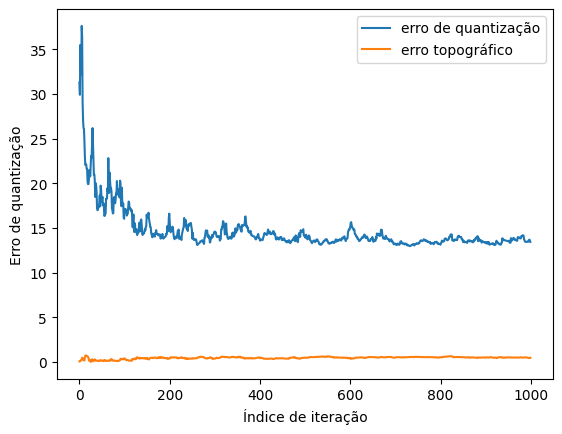

In [14]:
# Eu uso topografia linear som
som_shape = (1, 5)

som = MiniSom(som_shape[0], som_shape[1], data.shape[1], sigma=0.5, learning_rate=0.5)

max_iter = 1000
q_error = []
t_error = []

for i in range(max_iter):
    rand_i = np.random.randint(len(data))
    som.update(data[rand_i], som.winner(data[rand_i]), i, max_iter)
    q_error.append(som.quantization_error(data))
    t_error.append(som.topographic_error(data))

plt.plot(np.arange(max_iter), q_error, label='erro de quantização')
plt.plot(np.arange(max_iter), t_error, label='erro topográfico')
plt.ylabel('Erro de quantização')
plt.xlabel('Índice de iteração')
plt.legend()
plt.show()

### Gráfico de Resultados

In [13]:
# cada neurônio representa um cluster
winner_coordinates = np.array([som.winner(x) for x in data]).T

# com np.ravel_multi_index, convertemos as coordenadas bidimensionais
# em um índice monodimensional
cluster_index = np.ravel_multi_index(winner_coordinates, som_shape)

# Plotando os clusters 
plt.figure(figsize=(10,8))

for c in np.unique(cluster_index):
    plt.scatter(data[cluster_index == c, 0],
                data[cluster_index == c, 1], label='cluster='+str(c), alpha=.7)

# Plotando centróides
for centroid in som.get_weights():
    plt.scatter(centroid[:,Q 0], centroid[:, 1], marker='x', 
                s=10, linewidths=20, color='k') # label='centróide'
    
plt.title("Clusters de Clientes")
plt.xlabel("Renda Anual (k$)")
plt.ylabel("Pontuação de Gastos (1-100)")
plt.legend();

SyntaxError: invalid syntax. Perhaps you forgot a comma? (1262002943.py, line 17)

## Kohonen

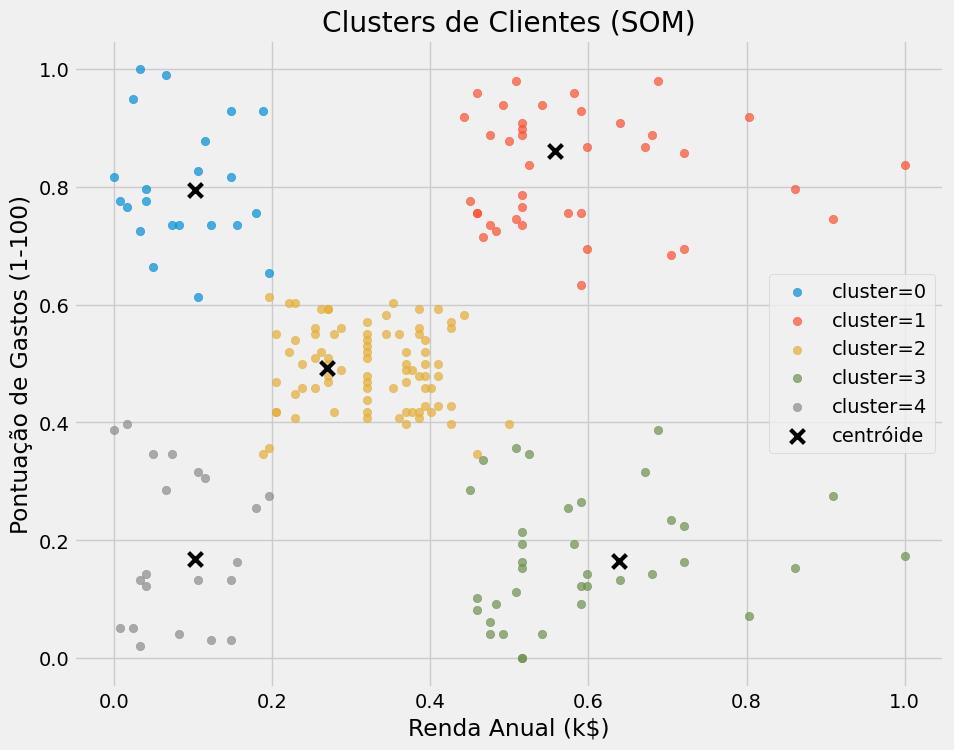

In [21]:
# Importar bibliotecas necessárias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from minisom import MiniSom

# Carregar o dataset
DATA_DIR = './dataset/Mall_Customers.csv'
df = pd.read_csv(DATA_DIR)

# Selecionar Renda Anual e Pontuação de Gastos como nossas características
features = df[['Annual Income (k$)', 'Spending Score (1-100)']]
data = features.values

# Normalizar os dados
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data = scaler.fit_transform(data)

# Configurar e treinar o SOM
som_shape = (1, 5)  # Definindo a topologia linear com 5 neurônios
som = MiniSom(som_shape[0], som_shape[1], data.shape[1], sigma=0.5, learning_rate=0.5)
som.random_weights_init(data)
som.train_random(data, 1000)  # Treinar o SOM com 1000 iterações

# Obter os clusters
winner_coordinates = np.array([som.winner(x) for x in data]).T
cluster_index = np.ravel_multi_index(winner_coordinates, som_shape)

# Plotar os clusters
plt.figure(figsize=(10, 8))
for c in np.unique(cluster_index):
    plt.scatter(data[cluster_index == c, 0], data[cluster_index == c, 1], label='cluster='+str(c), alpha=.7)

# Plotar centróides
for centroid in som.get_weights():
    plt.scatter(centroid[:, 0], centroid[:, 1], marker='x', s=100, linewidths=3, color='k', label='centróide')

plt.title("Clusters de Clientes (SOM)")
plt.xlabel("Renda Anual (k$)")
plt.ylabel("Pontuação de Gastos (1-100)")
plt.legend()
plt.show()

## ART

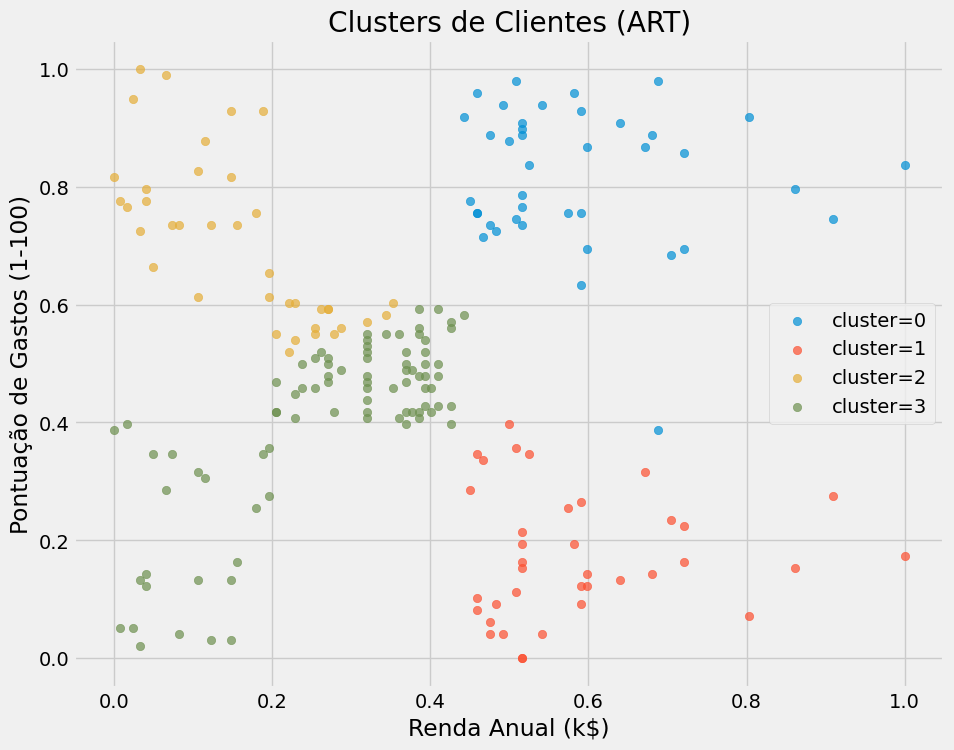

In [22]:
# Importar bibliotecas necessárias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Carregar o dataset
DATA_DIR = './dataset/Mall_Customers.csv'
df = pd.read_csv(DATA_DIR)

# Selecionar Renda Anual e Pontuação de Gastos como nossas características
features = df[['Annual Income (k$)', 'Spending Score (1-100)']]
data = features.values

# Normalizar os dados
scaler = MinMaxScaler()
data = scaler.fit_transform(data)

# Implementar ART
class ART:
    def __init__(self, vigilance=0.5):
        self.vigilance = vigilance
        self.weights = []

    def train(self, data):
        for sample in data:
            if not self.weights:
                self.weights.append(sample)
            else:
                for i, weight in enumerate(self.weights):
                    if np.linalg.norm(sample - weight) <= self.vigilance:
                        self.weights[i] = (self.weights[i] + sample) / 2
                        break
                else:
                    self.weights.append(sample)

    def predict(self, data):
        labels = []
        for sample in data:
            for i, weight in enumerate(self.weights):
                if np.linalg.norm(sample - weight) <= self.vigilance:
                    labels.append(i)
                    break
            else:
                labels.append(len(self.weights))
        return labels

# Configurar e treinar o ART
art = ART(vigilance=0.5)
art.train(data)

# Obter os clusters
labels = art.predict(data)

# Plotar os clusters
plt.figure(figsize=(10, 8))
for c in np.unique(labels):
    plt.scatter(data[labels == c, 0], data[labels == c, 1], label='cluster='+str(c), alpha=.7)

plt.title("Clusters de Clientes (ART)")
plt.xlabel("Renda Anual (k$)")
plt.ylabel("Pontuação de Gastos (1-100)")
plt.legend()
plt.show()

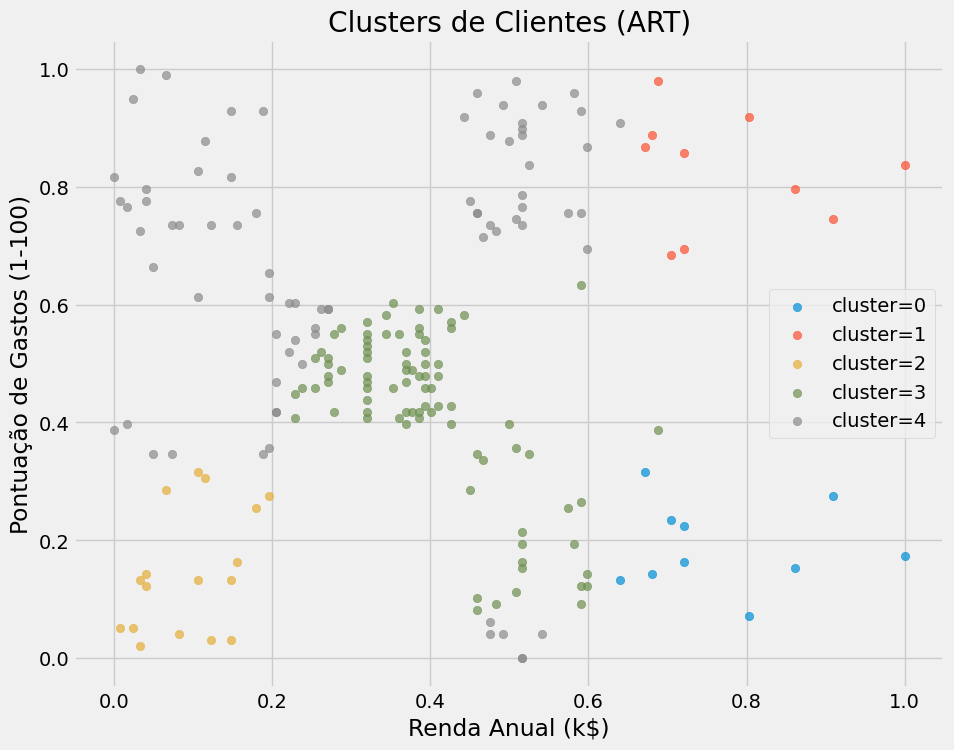

In [23]:
# Importar bibliotecas necessárias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Carregar o dataset
DATA_DIR = './dataset/Mall_Customers.csv'
df = pd.read_csv(DATA_DIR)

# Selecionar Renda Anual e Pontuação de Gastos como nossas características
features = df[['Annual Income (k$)', 'Spending Score (1-100)']]
data = features.values

# Normalizar os dados
scaler = MinMaxScaler()
data = scaler.fit_transform(data)

# Implementar ART
class ART:
    def __init__(self, vigilance=0.5):
        self.vigilance = vigilance
        self.weights = []

    def train(self, data):
        for sample in data:
            if not self.weights:
                self.weights.append(sample)
            else:
                for i, weight in enumerate(self.weights):
                    if np.linalg.norm(sample - weight) <= self.vigilance:
                        self.weights[i] = (self.weights[i] + sample) / 2
                        break
                else:
                    self.weights.append(sample)

    def predict(self, data):
        labels = []
        for sample in data:
            for i, weight in enumerate(self.weights):
                if np.linalg.norm(sample - weight) <= self.vigilance:
                    labels.append(i)
                    break
            else:
                labels.append(len(self.weights))
        return labels

# Configurar e treinar o ART
art = ART(vigilance=0.3)  # Ajuste o valor de vigilância para obter 5 classes
art.train(data)

# Obter os clusters
labels = art.predict(data)

# Plotar os clusters
plt.figure(figsize=(10, 8))
for c in np.unique(labels):
    plt.scatter(data[labels == c, 0], data[labels == c, 1], label='cluster='+str(c), alpha=.7)

plt.title("Clusters de Clientes (ART)")
plt.xlabel("Renda Anual (k$)")
plt.ylabel("Pontuação de Gastos (1-100)")
plt.legend()
plt.show()

In [24]:
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import pandas as pd

# Carregar os dados
DATA_DIR = './Mall_Customers.csv'
df = pd.read_csv(DATA_DIR)

# Selecionar Renda Anual e Pontuação de Gastos como nossas características
features = df[['Annual Income (k$)', 'Spending Score (1-100)']]
data = features.values

# Definir o número de clusters
n_clusters = 5

# Inicializar o modelo AgglomerativeClustering
agg_clustering = AgglomerativeClustering(n_clusters=n_clusters)

# Treinar o modelo
labels = agg_clustering.fit_predict(data)

# Plotar os clusters
plt.figure(figsize=(10, 8))

for c in np.unique(labels):
    plt.scatter(data[labels == c, 0],
                data[labels == c, 1], label='Cluster='+str(c), alpha=.7)

plt.title("Clusters de Clientes (Agglomerative Clustering)")
plt.xlabel("Renda Anual (k$)")
plt.ylabel("Pontuação de Gastos (1-100)")
plt.legend()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: './Mall_Customers.csv'

## Resultado Final
Aqui podemos ver que existem 5 clusters de clientes com base na renda anual e na pontuação de gastos:

Cluster 0: Alta renda, baixo gasto

Cluster 1: Alta renda, alto gasto

Cluster 2: Baixa renda, alto gasto

Cluster 3: Renda média, gasto médio

Cluster 4: Baixa renda, baixo gasto